**Data Visualization of DeFi Trends Over Time**

This script will create 3 charts for each of Total Value Locked, Total Projects, Total Pools and Liquid Staking Pools. 

The 3 charts will be: 

1. Bar charts across time
2. Bar charts for each of the largest chains
3. Bar chart displayed vertically showing the percentage change across 7 days of each of the largest chains



In [1]:
# Importing libraries and dependencies
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
from PIL import Image
from io import BytesIO
from matplotlib.offsetbox import (OffsetImage, AnnotationBbox)
from datetime import timedelta
import matplotlib.dates as mdates

#importing data

data = pd.read_csv(r'/Users/karolk/Python_Work/Data_Sets/Global_Data/DeFi_Global_DB.csv', index_col=0)
pd.set_option("display.max.columns", None)
pd.set_option("display.precision", 4)
pd.options.display.float_format = '{:,.2f}'.format

# in data remove anything that was marked as an outlier
data = data[data['outlier'] == False]

# remove 'camelot-v2' project from dataset
data = data[data['project'] != 'camelot-v2']



In [2]:
#modifying the data set to make sure 'date' is in datetime format and a new column for pools which are one-sided ETH pools
data['eth_one_sided'] = np.where((data['symbol'].str.contains('eth', case=False, na=False)) & (data['ilRisk'] == 'no'), True, False)
data['date'] = pd.to_datetime(data['date'])


In [3]:
#selecting only the colums needed to create the visualizations
time_data = data[['date', 'chain', 'project', 'pool', 'tvlUsd', 'stablecoin', 'outlier', 'exposure', 'eth_one_sided']]

#find the min of the date column
min_date = time_data['date'].min()

#change the smallest date in the date column to '2023-01-01'
time_data['date'] = time_data['date'].replace(min_date, '2023-01-01')

#create a variable called start of year which is the min date of the date column
start_of_year = time_data['date'].min()

#cleaning up the data by removing outliers and pools with no TVL
time_data = time_data[time_data['outlier'] == False]
time_data = time_data[time_data['tvlUsd'] > 0]

# setting the date field in time to datetime
time_data['date'] = pd.to_datetime(time_data['date'])

#creating a list for liquid staking pools
liquid_stakers = ['lido', 'rocket-pool', 'coinbase-wrapped-staked-eth', 'stakewise', 'frax-ether', 'stafi', 'stakehound', 'stader', 'bitfrost-liquid-staking', 'binance-staked-eth', 'swell', 'ankr']

#create a new column in 'time_data' that is 'True' if the project is in the liquid_stakers list
time_data['liquid_staker'] = time_data['project'].isin(liquid_stakers)



/var/folders/gn/b1hbt5mx3mg2y8p3tgg7g7xh0000gn/T/ipykernel_1922/3259730699.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time_data['date'] = time_data['date'].replace(min_date, '2023-01-01')


In [4]:
#creating a list of dates that will be shown in the charts. The list should include: today's date, the dates over the last 7 days, the first of the month of the last 6 months, the first day of this year

today = pd.to_datetime('today').normalize()
last_week = pd.date_range(end=today, periods=8, freq='D')
last_six_months = pd.date_range(end=today, periods=6, freq='MS')
first_of_year = pd.date_range(end=today, periods=1, freq='YS')

dates = last_week.union(last_six_months).union(first_of_year)
dates = dates.sort_values(ascending=False)

#matching the dates format to datetime
dates = pd.to_datetime(dates)

#display(dates)

In [5]:
#select all liquid stakers from time_data for the last 7 days
liquid_stakers_week = time_data[time_data['liquid_staker'] == True]
liquid_stakers_week = liquid_stakers_week[liquid_stakers_week['date'] >= today - timedelta(days=7)]

liquid_stakers_week

,date,chain,project,pool,tvlUsd,stablecoin,outlier,exposure,eth_one_sided,liquid_staker
id,,,,,,,,,,
2505140,2023-12-03,Fantom,ankr,f0241c03-735e-41b2-ab1f-511dfc7b2c38,"228,984.00",False,False,single,False,True
2492586,2023-12-02,Fantom,ankr,f0241c03-735e-41b2-ab1f-511dfc7b2c38,"221,630.00",False,False,single,False,True
2500469,2023-12-03,Ethereum,ankr,e201dbed-63fa-48e2-bfa2-f56e730167d2,"55,289,576.00",False,False,single,True,True
2487901,2023-12-02,Ethereum,ankr,e201dbed-63fa-48e2-bfa2-f56e730167d2,"53,577,784.00",False,False,single,True,True
2500374,2023-12-03,Ethereum,rocket-pool,d4b3c522-6127-4b89-bedf-83641cdcd2eb,"2,229,960,502.00",False,False,single,True,True
...,...,...,...,...,...,...,...,...,...,...
319,2023-12-09,Ethereum,stafi,b2fe5b13-eca4-47cc-b3fd-1de24a296018,"15,862,484.00",False,False,single,True,True
405,2023-12-09,BSC,ankr,76ce5019-2483-4d1b-ae06-01b890360045,"11,438,684.00",False,False,single,False,True
2560,2023-12-09,Polygon,ankr,59b0f1a4-a35b-48dd-8fc0-5627f7ec1a80,"776,011.00",False,False,single,False,True


In [6]:
# creating 3 separate dataframes for each of the charts
# starting with TVL
# create a dataframe called tvl_data which takes all of time_data where 'liquid_staker' is 'False', eliminating double countnig due to staked ETH
tvl_data_start = time_data[time_data['liquid_staker'] == False]

# creating a dataframe that has the total TVL for each day broken down by 'stablecoin'
tvl_data = tvl_data_start.groupby(['date', 'stablecoin'])['tvlUsd'].sum().reset_index()

#selecting only the data for the dates in the 'dates' list
tvl_data = tvl_data[tvl_data['date'].isin(dates)]

#create dataframe that has total TVL for each date
tvl_data_total = tvl_data.groupby(['date'])['tvlUsd'].sum().reset_index()

# changing the date column to string for easier reading in chart
tvl_data_total['date'] = tvl_data_total['date'].dt.strftime('%Y-%m-%d')

#create dateframe that total TVL for each date where stablecoin is 'True'
tvl_data_stable = tvl_data[tvl_data['stablecoin'] == True]

#changing the date column to string for easier reading in chart
tvl_data_stable['date'] = tvl_data_stable['date'].dt.strftime('%Y-%m-%d')

# creating a dataframe that has the total TVL by chain for each day
tvl_data_chain = tvl_data_start.groupby(['date', 'chain'])['tvlUsd'].sum().reset_index()

# create a new dataframe that has selects only today's date and the date 1 week ago
tvl_data_week = tvl_data_chain[tvl_data_chain['date'].isin([today, today - timedelta(days=7)])]

#create a pivot table that has the TVL for each chain for today and 1 week ago
tvl_data_week = tvl_data_week.pivot(index='chain', columns='date', values='tvlUsd').reset_index()

#add a column that calculates the percentage change in TVL for each chain
tvl_data_week['pct_change'] = (tvl_data_week[today] - tvl_data_week[today - timedelta(days=7)]) / tvl_data_week[today - timedelta(days=7)]

# keep only the columns needed for the chart: today's date, chain, today's tvl and the percentage change
tvl_data_week = tvl_data_week[[today, 'chain', 'pct_change']]

# keep only the 10 largest chains by TVL
tvl_data_week = tvl_data_week.nlargest(10, today)

#rename the columns to make them more readable
tvl_data_week = tvl_data_week.rename(columns={today: 'tvl', 'chain': 'Chain', 'pct_change': 'Change'})

# multipling Change by 100 to get the percentage change
tvl_data_week['Change'] = tvl_data_week['Change'] * 100




/var/folders/gn/b1hbt5mx3mg2y8p3tgg7g7xh0000gn/T/ipykernel_1922/4095056824.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tvl_data_stable['date'] = tvl_data_stable['date'].dt.strftime('%Y-%m-%d')


In [7]:
# creating a dataframe with total projects by day
projects_data = time_data.groupby(['date'])['project'].nunique().reset_index()

#selecting only the data for the dates in the 'dates' list
projects_data = projects_data[projects_data['date'].isin(dates)]

#changing the date column to string for easier reading in chart
projects_data['date'] = projects_data['date'].dt.strftime('%Y-%m-%d')

# creating a dataframe that has the total projects by chain for each day
projects_data_chain = time_data.groupby(['date', 'chain'])['project'].nunique().reset_index()

# create a new dataframe that has selects only today's date and the start of the year
projects_data_year = projects_data_chain[projects_data_chain['date'].isin([today, start_of_year])]

#create a pivot table that has the projects for each chain for today and the start of the year
projects_data_year = projects_data_year.pivot(index='chain', columns='date', values='project').reset_index()

#add a column that calculates the change in number of projects for each chain
projects_data_year['project_change'] = projects_data_year[today] - projects_data_year[start_of_year]

# keep only the columns needed for the chart: today's date, chain, today's projects and the change in projects
projects_data_year = projects_data_year[[today, 'chain', 'project_change']]

# keep only the 10 largest chains by number of projects
projects_data_year = projects_data_year.nlargest(10, today)

# rename the columns to make them more readable
projects_data_year = projects_data_year.rename(columns={today: 'Projects', 'chain': 'Chain', 'project_change': 'Change'})

#projects_data_year

In [8]:
#creating a dataframe with total pools by day
pools_data = time_data.groupby(['date'])['pool'].nunique().reset_index()

#selecting only the data for the dates in the 'dates' list
pools_data = pools_data[pools_data['date'].isin(dates)]

#changing the date column to string for easier reading in chart
pools_data['date'] = pools_data['date'].dt.strftime('%Y-%m-%d')

# creating a dataframe that has the total stablecoin pools
pools_data_stable = time_data[time_data['stablecoin'] == True]

# creating a dataframe that has the total stablecoin pools for each day
pools_data_stable = pools_data_stable.groupby(['date'])['pool'].nunique().reset_index()

# selecting only the data for the dates in the 'dates' list
pools_data_stable = pools_data_stable[pools_data_stable['date'].isin(dates)]

# changing the date column to string for easier reading in chart
pools_data_stable['date'] = pools_data_stable['date'].dt.strftime('%Y-%m-%d')

# creating a dataframe that has the total pools by chain for each day
pools_data_chain = time_data.groupby(['date', 'chain'])['pool'].nunique().reset_index()

# create a new dataframe that has selects only today's date and the date a week ago
pools_data_week = pools_data_chain[pools_data_chain['date'].isin([today, today - timedelta(days=7)])]

#create a pivot table that has the pools for each chain for today and 1 week ago
pools_data_week = pools_data_week.pivot(index='chain', columns='date', values='pool').reset_index()

#add a column that calculates the change in number of pools for each chain
pools_data_week['pool_change'] = pools_data_week[today] - pools_data_week[today - timedelta(days=7)]

# keep only the columns needed for the chart: today's date, chain, today's pools and the change in pools
pools_data_week = pools_data_week[[today, 'chain', 'pool_change']]

# keep only the 10 largest chains by number of pools
pools_data_week = pools_data_week.nlargest(10, today)

# rename the columns to make them more readable
pools_data_week = pools_data_week.rename(columns={today: 'Pools', 'chain': 'Chain', 'pool_change': 'Change'})

#pools_data_week

In [9]:
#creating a dataframe for liquid staking pools
liquid_data = time_data[time_data['project'].isin(liquid_stakers)]

#keep only the columns needed for the chart
liquid_data = liquid_data[['date', 'project', 'tvlUsd']]

#create a dataframe to track total TVL for liquid staking pools
liquid_data_tvl = liquid_data.groupby(['date'])['tvlUsd'].sum().reset_index()

#keep only the dates in the 'dates' list
liquid_data_tvl = liquid_data_tvl[liquid_data_tvl['date'].isin(dates)]

# change the date column to string for easier reading in chart
liquid_data_tvl['date'] = liquid_data_tvl['date'].dt.strftime('%Y-%m-%d')

#create a dataframe to track total TVL in each of the projects in liquid_data
liquid_data_projects = liquid_data.groupby(['date', 'project'])['tvlUsd'].sum().reset_index()

#keep only the dates for today and one week ago
liquid_data_projects = liquid_data_projects[liquid_data_projects['date'].isin([today, today - timedelta(days=7)])]

#create a pivot table that has the TVL for each project for today and 1 week ago
liquid_data_projects = liquid_data_projects.pivot(index='project', columns='date', values='tvlUsd').reset_index()

#sort the data by today's TVL
liquid_data_projects = liquid_data_projects.sort_values(by=today, ascending=False)

#add a column that calculates the percentage change in TVL for each project
liquid_data_projects['pct_change'] = (liquid_data_projects[today] - liquid_data_projects[today - timedelta(days=7)]) / liquid_data_projects[today - timedelta(days=7)]

# keep only the columns needed for the chart: today's date, project, today's tvl and the percentage change
liquid_data_projects = liquid_data_projects[[today, 'project', 'pct_change']]

# changing columns to make them more readable
liquid_data_projects = liquid_data_projects.rename(columns={today: 'TVL', 'project': 'Project', 'pct_change': 'Change'})

# adjusting change to be a percentage
liquid_data_projects['Change'] = liquid_data_projects['Change'] * 100

#liquid_data_projects

In [10]:
# setting up items prior to creating the charts

#importing image for watermark
img = Image.open(r'/Users/karolk/Python_Work/Data_Sets/logo.png')

#creating string that says "Data updated as of: mmm dd yyyy"
date = data['date'].max()
date = pd.to_datetime(date)
date = date.strftime('%b %d %Y')
date = 'Data updated as of: ' + date

#setting theme for all plots
sns.set_theme(style="ticks", context='talk')

#setting up font for all plots
fontpath = '/System/Library/Fonts/Optima.ttc'
prop = font_manager.FontProperties(fname=fontpath)
plt.rcParams['font.family'] = prop.get_name()

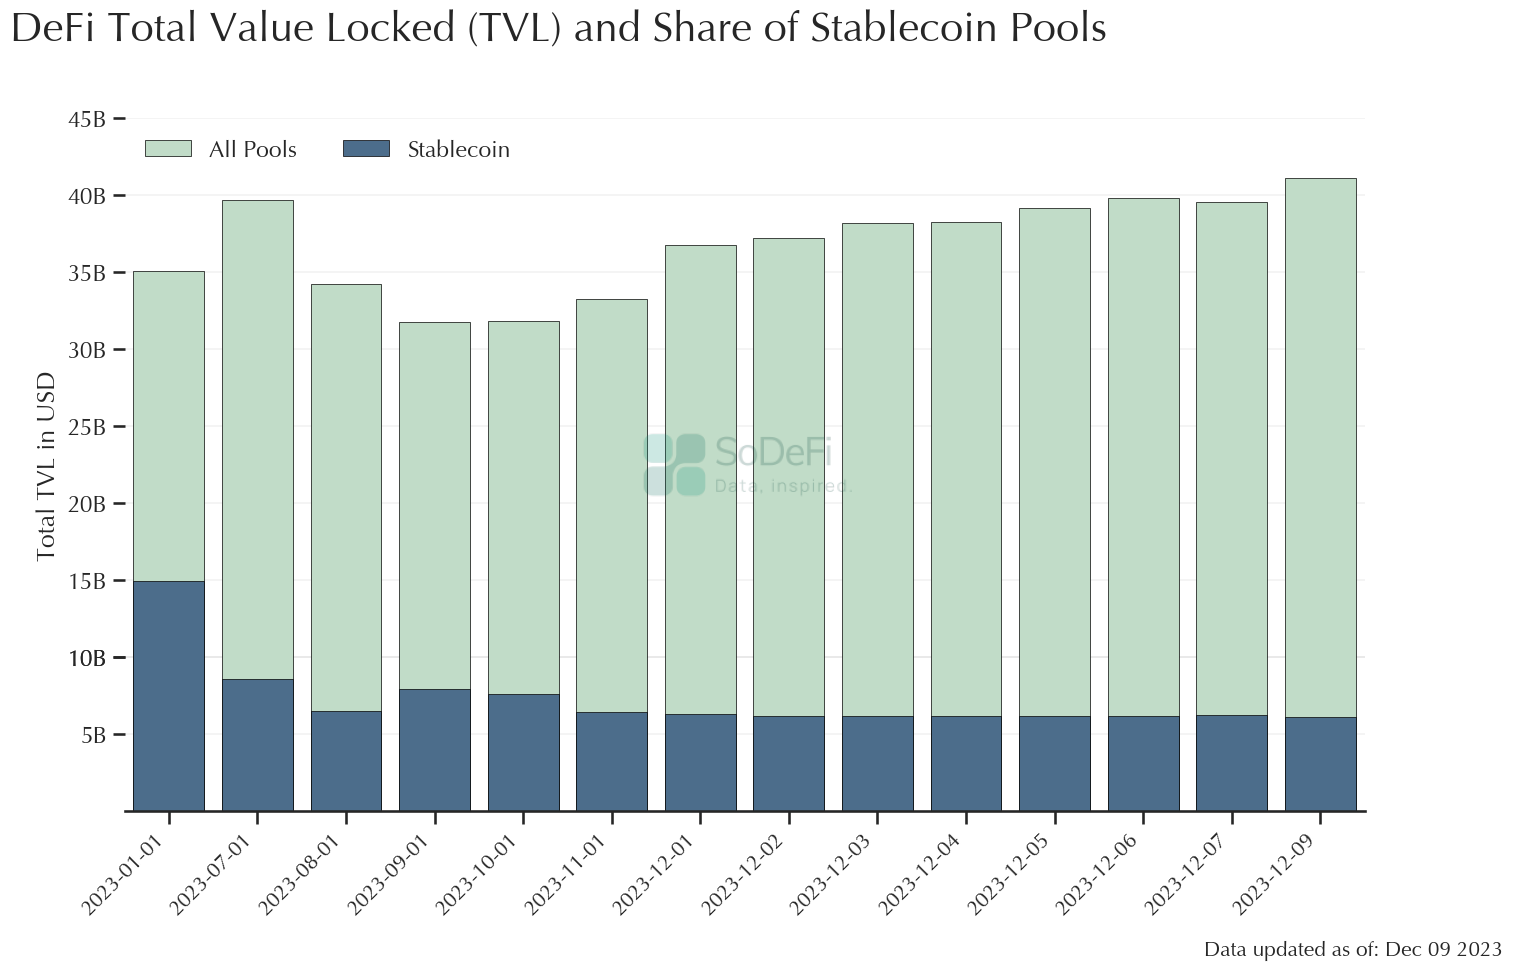

In [11]:
# creating figure 1A - total TVL over time

#plot the total TVL by date
fig, ax = plt.subplots()
ax.figure.set_size_inches(16, 9)

#plotting the data
ax = sns.barplot(x='date', y='tvlUsd', data=tvl_data_total, label='All Pools', color='#BCE0C6', linewidth=0.5, edgecolor='black')
ax = sns.barplot(x='date', y='tvlUsd', data=tvl_data_stable, label='Stablecoin', color='#416E96', linewidth=0.5, edgecolor='black')

#set a legend for the chart
plt.legend(ncol=2, loc="upper left", frameon=False)

#despine the chart
sns.despine(left=True)

#adjusting the y axis ticks scale
plt.yticks([ 5000000000, 10000000000,15000000000,10000000000, 20000000000, 25000000000, 30000000000, 35000000000, 40000000000, 45000000000],
           ['5B', '10B', '15B', '10B', '20B', '25B', '30B', '35B', '40B', '45B'])

#add light grey grid lines
plt.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5, axis='y')


#set title and labels for the chart
ax.set_title('DeFi Total Value Locked (TVL) and Share of Stablecoin Pools',
             y=1.1, size=30, weight='bold', x=0.35)
ax.set_xlabel(None)
ax.set_ylabel('Total TVL in USD')

#adding a string of when data was updated to the  right bottom corner of exhibit
plt.text(0.8, -0.05, date, fontsize=15, transform=plt.gcf().transFigure)

#rotating the x-axis labels
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", size=15)

#adding watermark
imagebox = OffsetImage(img, zoom=0.8, alpha=0.2)
imagebox.image.axes = ax
ao = AnnotationBbox(imagebox, (0.5, 0.5), xycoords='axes fraction', bboxprops={'lw':0})
ao.patch.set_alpha(0)
ax.add_artist(ao)

#saving chart as png file in folder called 'Charts'
fig.savefig('/Users/karolk/Python_Work/DeFi_Viz/Figures/1A.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()
plt.cla()
plt.clf()
plt.close()

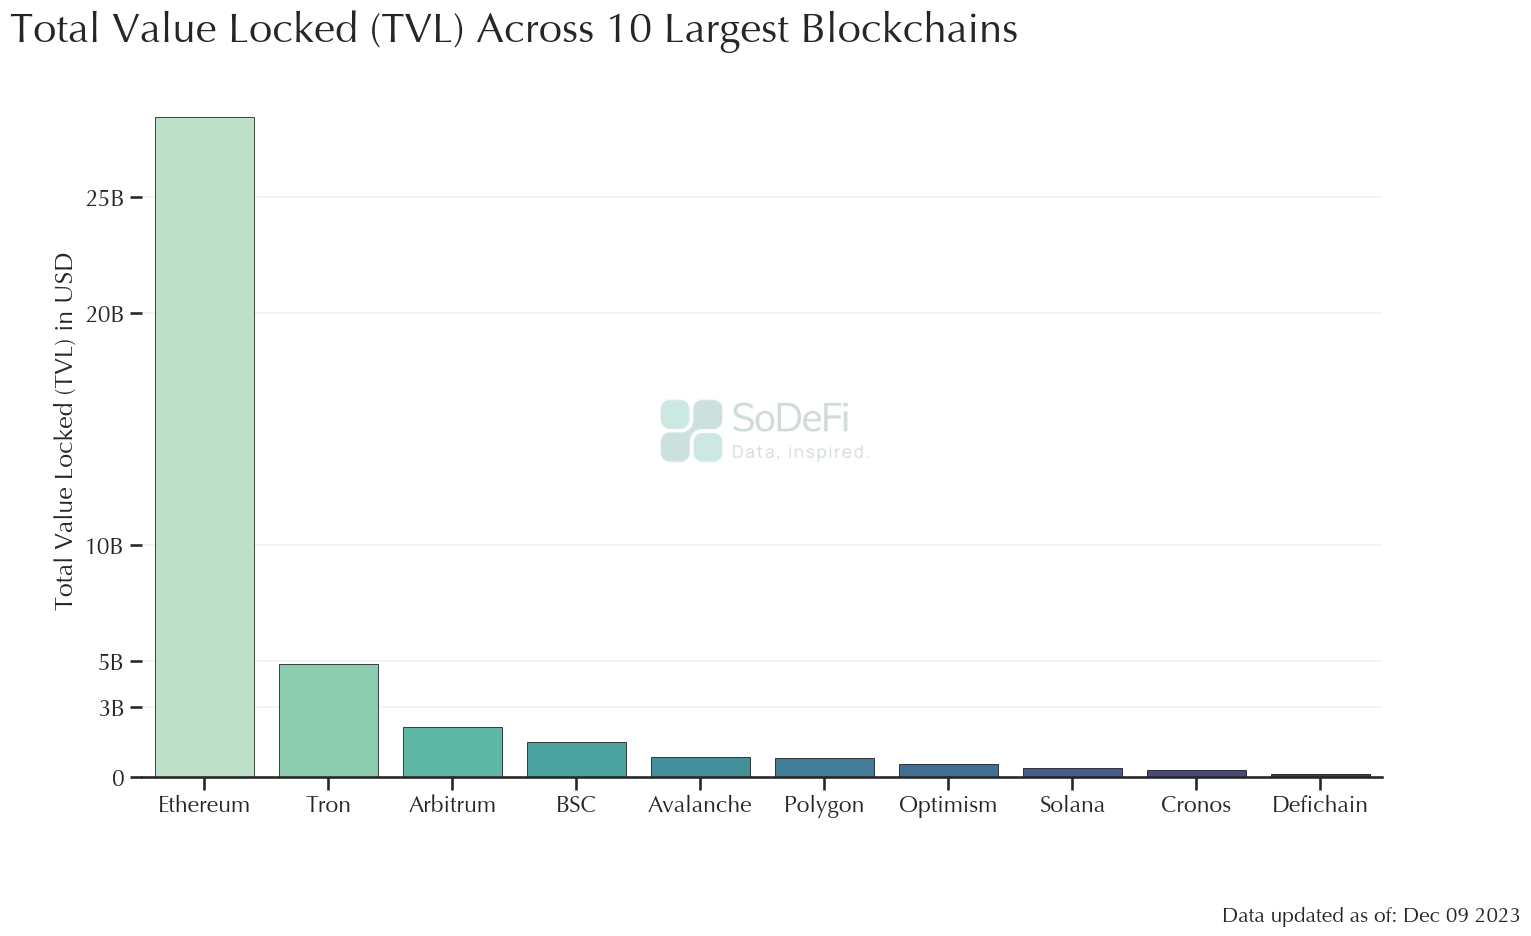

In [12]:
# creating figure 1B - TVL by the 10 largest chains

#create a chart of total TVL by chain
fig, ax = plt.subplots(figsize=(16,9))

#setting collor palette to 'makr_r'
sns.set_palette('mako_r', 12)

#charting the data
ax = sns.barplot(x='Chain', y='tvl', data=tvl_data_week, linewidth=0.5, edgecolor='black')

#setting up title and labels
ax.set_title('Total Value Locked (TVL) Across 10 Largest Blockchains',
             y=1.05, size=30, weight='bold', x=0.3)
ax.set(xlabel =None,
       ylabel = 'Total Value Locked (TVL) in USD')
sns.despine(left=True)
plt.grid(False)

#adding a string of when data was updated to the  right bottom corner of exhibit
plt.text(0.8, -0.05, date, fontsize=15, transform=plt.gcf().transFigure)

#adjusting the tick marks scale
plt.yticks([0, 3000000000, 5000000000, 10000000000, 20000000000, 25000000000],
           ['0', '3B', '5B', '10B', '20B', '25B'])

#adding watermark
imagebox = OffsetImage(img, zoom=0.8, alpha=0.2)
imagebox.image.axes = ax
ao = AnnotationBbox(imagebox, (0.5, 0.5), xycoords='axes fraction', bboxprops={'lw':0})
ao.patch.set_alpha(0)
ax.add_artist(ao)

plt.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5, axis='y')

#saving plot

fig.savefig('/Users/karolk/Python_Work/DeFi_Viz/Figures/1B.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()
plt.cla()
plt.clf()
plt.close()

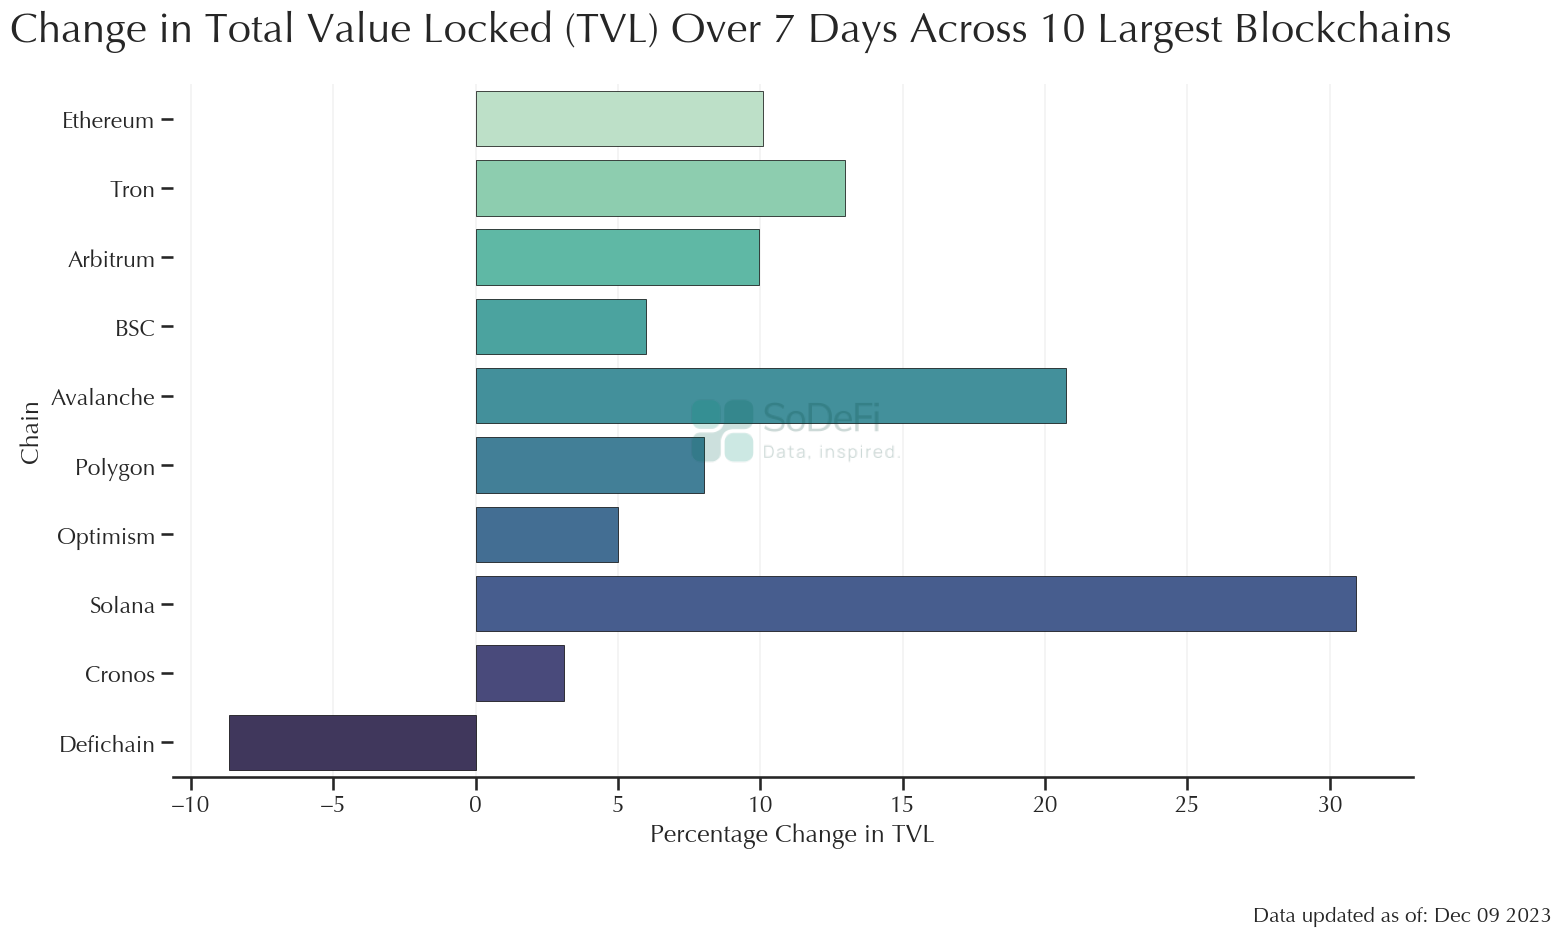

In [13]:
# creating figure 1C - Change in TVL over 7 Days

#create a chart of total TVL by chain
fig, ax = plt.subplots(figsize=(16,9))

#setting collor palette to 'makr_r'
sns.set_palette('mako_r', 12)

#charting the data
ax = sns.barplot(x='Change', y='Chain', data=tvl_data_week, linewidth=0.5, edgecolor='black')

#setting up title and labels
ax.set_title('Change in Total Value Locked (TVL) Over 7 Days Across 10 Largest Blockchains',
             y=1.05, size=30, weight='bold', x=0.45)
ax.set(xlabel ='Percentage Change in TVL',
       ylabel = 'Chain')
sns.despine(left=True)
plt.grid(False)

#adding a string of when data was updated to the  right bottom corner of exhibit
plt.text(0.8, -0.05, date, fontsize=15, transform=plt.gcf().transFigure)

#adding watermark
imagebox = OffsetImage(img, zoom=0.8, alpha=0.2)
imagebox.image.axes = ax
ao = AnnotationBbox(imagebox, (0.5, 0.5), xycoords='axes fraction', bboxprops={'lw':0})
ao.patch.set_alpha(0)
ax.add_artist(ao)

plt.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5, axis='x')

#saving plot

fig.savefig('/Users/karolk/Python_Work/DeFi_Viz/Figures/1C.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()
plt.cla()
plt.clf()
plt.close()

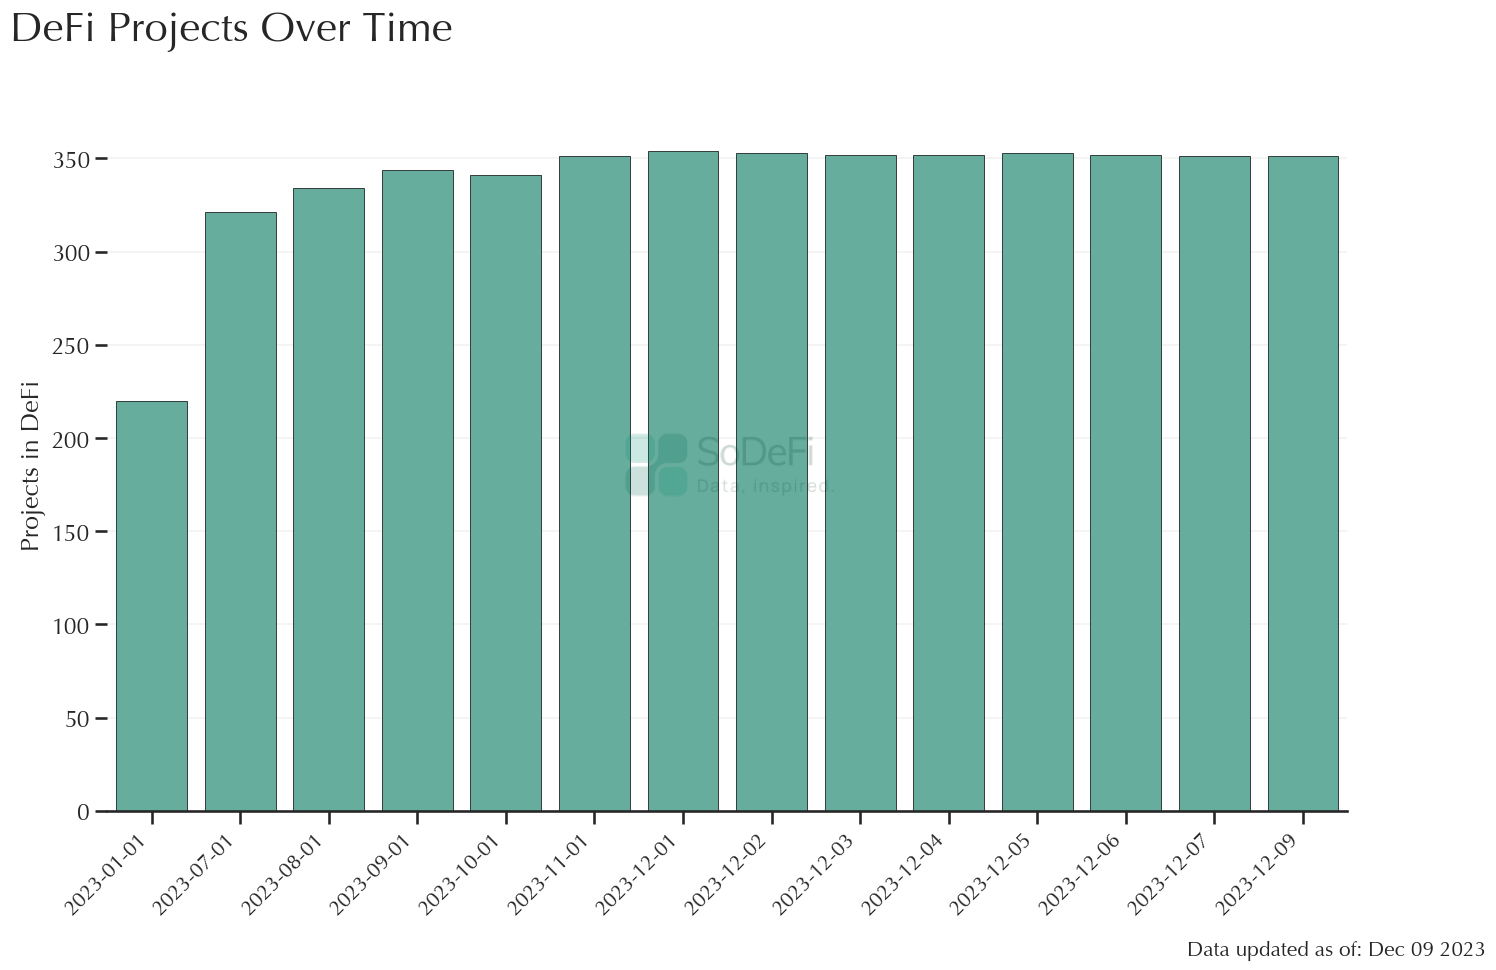

In [14]:
# creating figure 2A - total projects over time

#plot the total TVL by date
fig, ax = plt.subplots()
ax.figure.set_size_inches(16, 9)

#plotting the data
ax = sns.barplot(x='date', y='project', data=projects_data, color='#5AB9A4', linewidth=0.5, edgecolor='black')

#despine the chart
sns.despine(left=True)

#set title and labels for the chart
ax.set_title('DeFi Projects Over Time',
             y=1.1, size=30, weight='bold', x=0.1)
ax.set_xlabel(None)
ax.set_ylabel('Projects in DeFi')

#adding a string of when data was updated to the  right bottom corner of exhibit
plt.text(0.8, -0.05, date, fontsize=15, transform=plt.gcf().transFigure)

#rotating the x-axis labels
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", size=15)

#adding watermark
imagebox = OffsetImage(img, zoom=0.8, alpha=0.2)
imagebox.image.axes = ax
ao = AnnotationBbox(imagebox, (0.5, 0.5), xycoords='axes fraction', bboxprops={'lw':0})
ao.patch.set_alpha(0)
ax.add_artist(ao)

plt.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5, axis='y')

#saving chart as png file in folder called 'Charts'
fig.savefig('/Users/karolk/Python_Work/DeFi_Viz/Figures/2A.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()
plt.cla()
plt.clf()
plt.close()

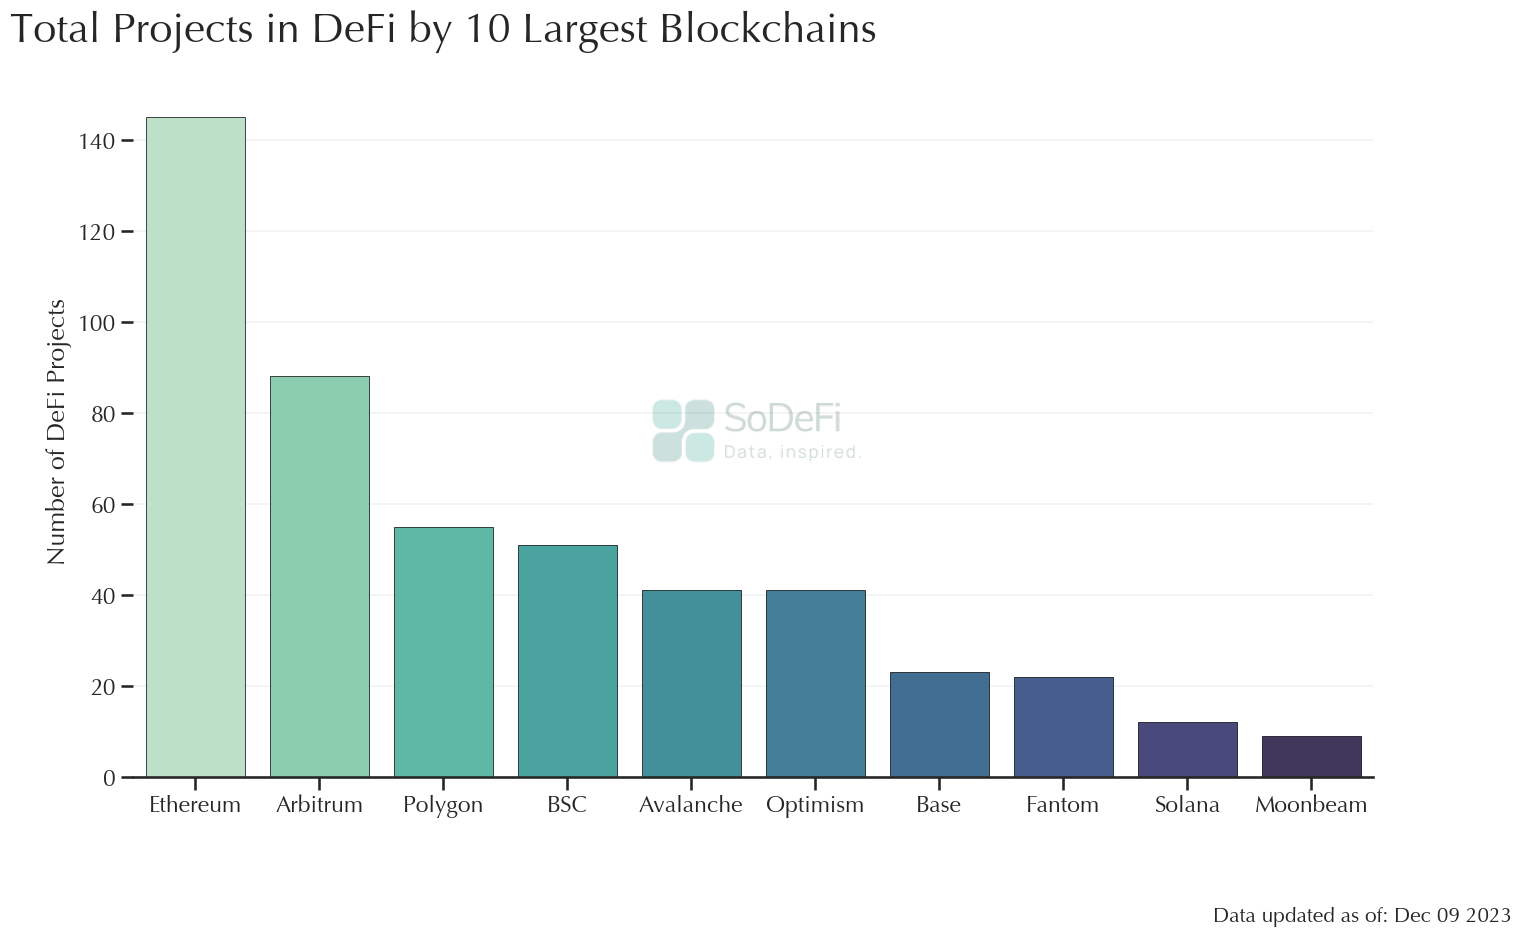

In [15]:
# creating figure 2B - TVL by the 10 largest chains

#create a chart of total TVL by chain
fig, ax = plt.subplots(figsize=(16,9))

#setting collor palette to 'makr_r'
sns.set_palette('mako_r', 12)

#charting the data
ax = sns.barplot(x='Chain', y='Projects', data=projects_data_year, linewidth=0.5, edgecolor='black')

#setting up title and labels
ax.set_title('Total Projects in DeFi by 10 Largest Blockchains',
             y=1.05, size=30, weight='bold', x=0.25)
ax.set(xlabel =None,
       ylabel = 'Number of DeFi Projects')
sns.despine(left=True)
plt.grid(False)

#adding a string of when data was updated to the  right bottom corner of exhibit
plt.text(0.8, -0.05, date, fontsize=15, transform=plt.gcf().transFigure)

#adding watermark
imagebox = OffsetImage(img, zoom=0.8, alpha=0.2)
imagebox.image.axes = ax
ao = AnnotationBbox(imagebox, (0.5, 0.5), xycoords='axes fraction', bboxprops={'lw':0})
ao.patch.set_alpha(0)
ax.add_artist(ao)

plt.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5, axis='y')

#saving plot

fig.savefig('/Users/karolk/Python_Work/DeFi_Viz/Figures/2B.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()
plt.cla()
plt.clf()
plt.close()

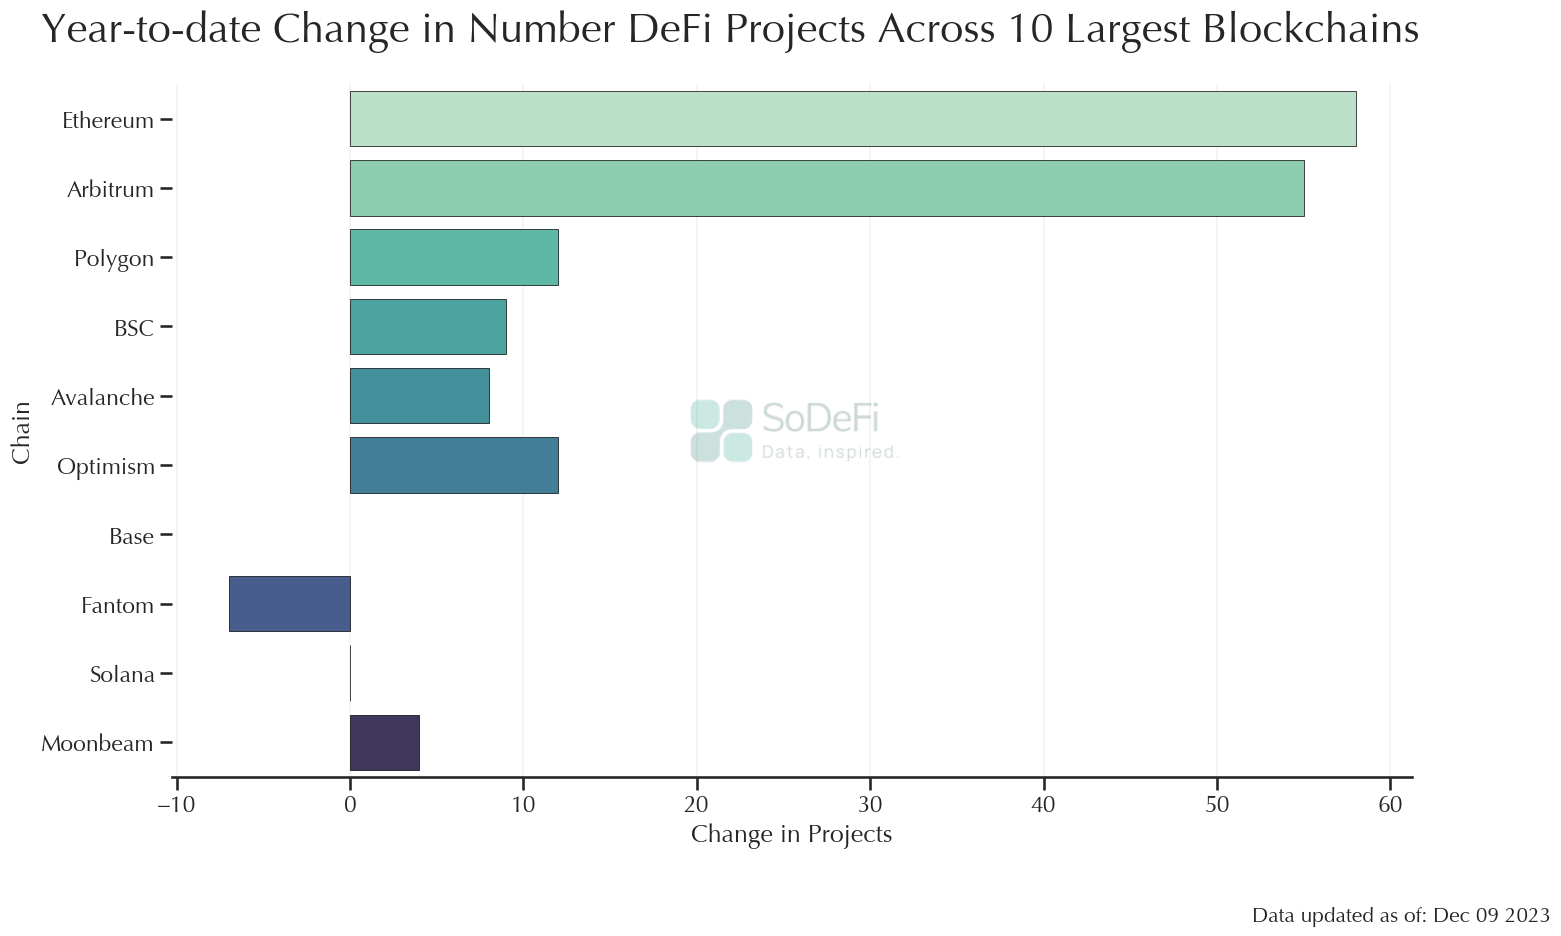

In [16]:
# creating figure 2C - Change in TVL over 7 Days

#create a chart of total TVL by chain
fig, ax = plt.subplots(figsize=(16,9))

#setting collor palette to 'makr_r'
sns.set_palette('mako_r', 12)

#charting the data
ax = sns.barplot(x='Change', y='Chain', data=projects_data_year, linewidth=0.5, edgecolor='black')

#setting up title and labels
ax.set_title('Year-to-date Change in Number DeFi Projects Across 10 Largest Blockchains',
             y=1.05, size=30, weight='bold', x=0.45)
ax.set(xlabel ='Change in Projects',
       ylabel = 'Chain')
sns.despine(left=True)
plt.grid(False)

#adding a string of when data was updated to the  right bottom corner of exhibit
plt.text(0.8, -0.05, date, fontsize=15, transform=plt.gcf().transFigure)

#adding watermark
imagebox = OffsetImage(img, zoom=0.8, alpha=0.2)
imagebox.image.axes = ax
ao = AnnotationBbox(imagebox, (0.5, 0.5), xycoords='axes fraction', bboxprops={'lw':0})
ao.patch.set_alpha(0)
ax.add_artist(ao)

plt.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5, axis='x')


#saving plot

fig.savefig('/Users/karolk/Python_Work/DeFi_Viz/Figures/2C.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()
plt.cla()
plt.clf()
plt.close()

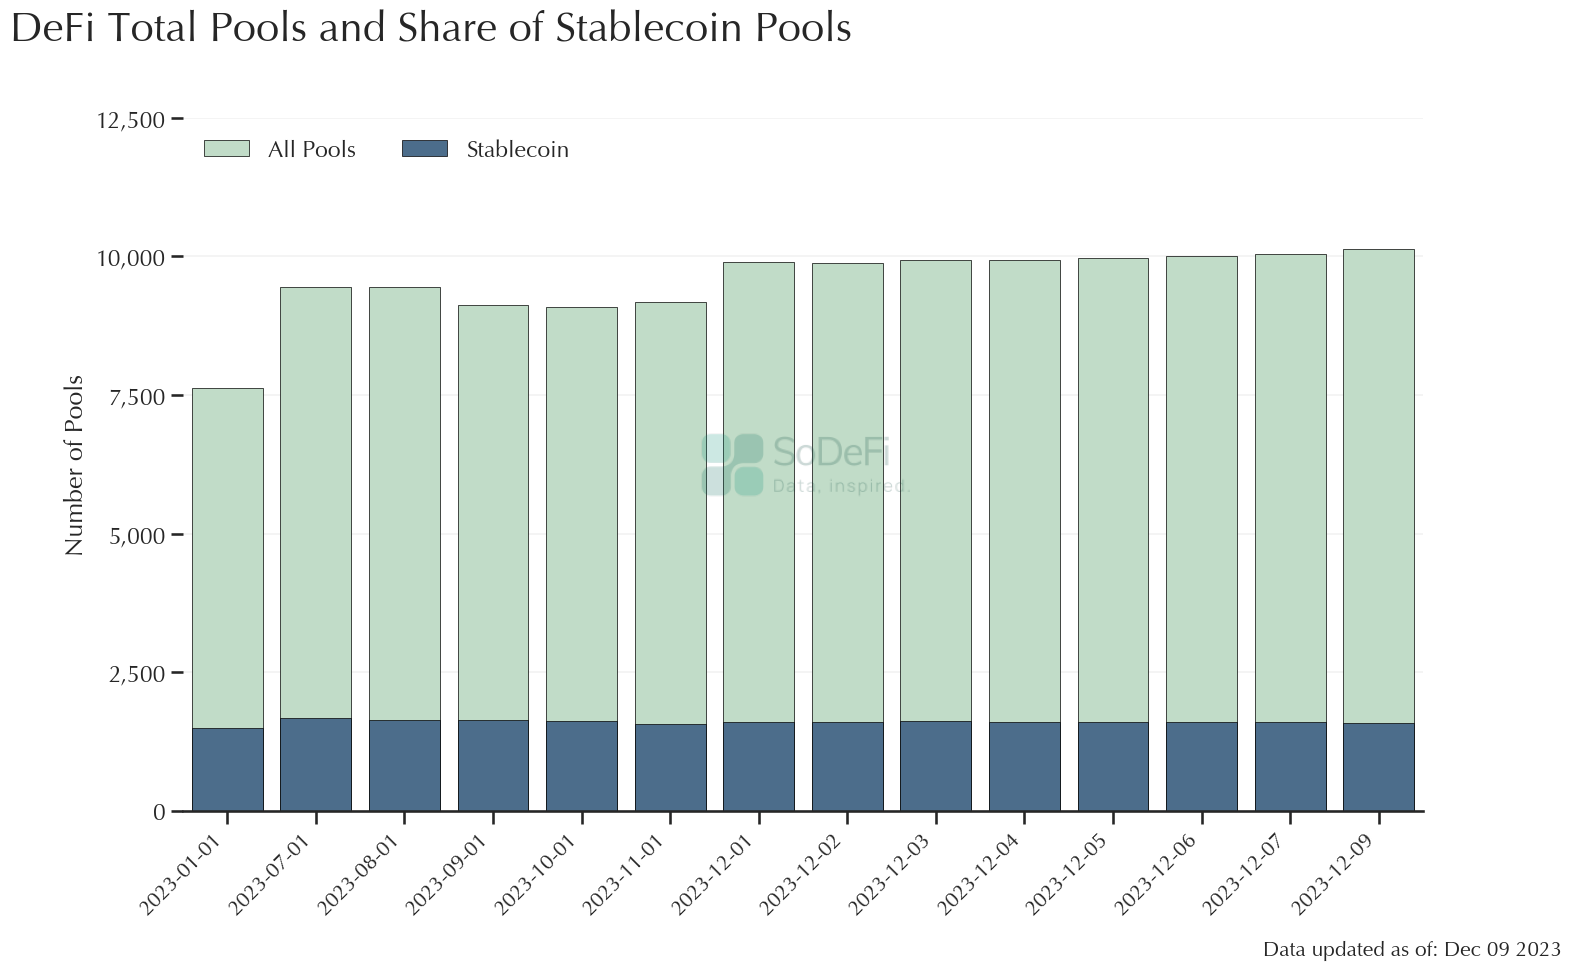

In [17]:
# creating figure 3A - total pools over time

#plot the total TVL by date
fig, ax = plt.subplots()
ax.figure.set_size_inches(16, 9)

#plotting the data
ax = sns.barplot(x='date', y='pool', data=pools_data, label='All Pools', color='#BCE0C6', linewidth=0.5, edgecolor='black')
ax = sns.barplot(x='date', y='pool', data=pools_data_stable, label='Stablecoin', color='#416E96', linewidth=0.5, edgecolor='black')

#set a legend for the chart
plt.legend(ncol=2, loc="upper left", frameon=False)

#despine the chart
sns.despine(left=True)


#set title and labels for the chart
ax.set_title('DeFi Total Pools and Share of Stablecoin Pools',
             y=1.1, size=30, weight='bold', x=0.2)
ax.set_xlabel(None)
ax.set_ylabel('Number of Pools')

# adjusting the y-axis for easier reading
ax.set_yticks([0, 2500, 5000, 7500, 10000, 12500],['0', '2,500', '5,000', '7,500', '10,000', '12,500'])

#adding a string of when data was updated to the  right bottom corner of exhibit
plt.text(0.8, -0.05, date, fontsize=15, transform=plt.gcf().transFigure)

#rotating the x-axis labels
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", size=15)

#adding watermark
imagebox = OffsetImage(img, zoom=0.8, alpha=0.2)
imagebox.image.axes = ax
ao = AnnotationBbox(imagebox, (0.5, 0.5), xycoords='axes fraction', bboxprops={'lw':0})
ao.patch.set_alpha(0)
ax.add_artist(ao)

plt.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5, axis='y')

#saving chart as png file in folder called 'Charts'
fig.savefig('/Users/karolk/Python_Work/DeFi_Viz/Figures/3A.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()
plt.cla()
plt.clf()
plt.close()

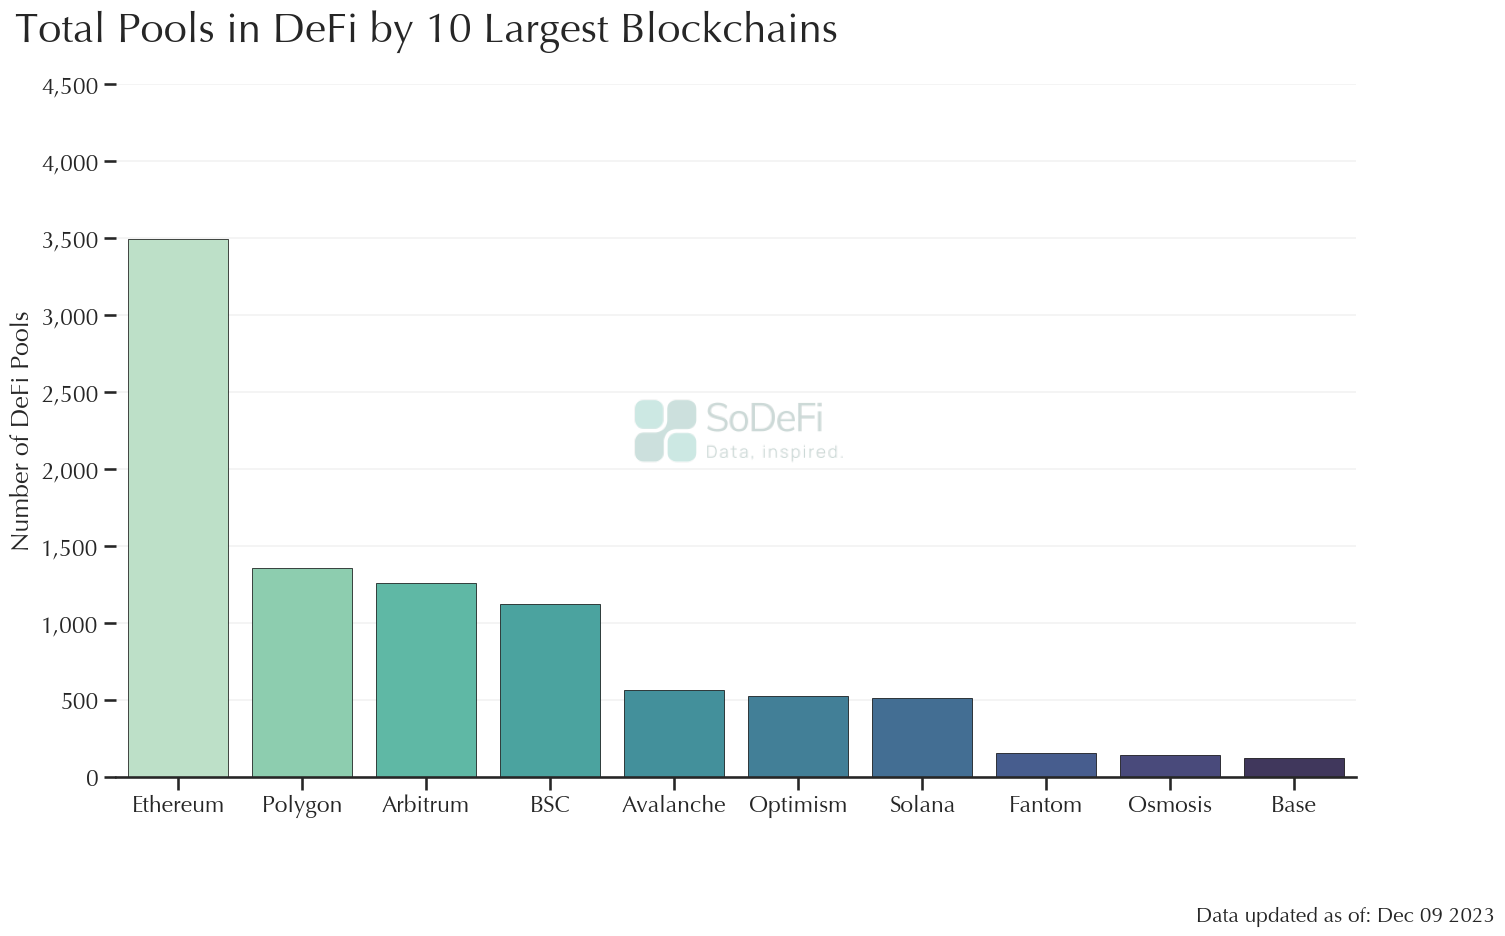

In [18]:
# creating figure 3B - Pools by the 10 largest chains

#create a chart of total TVL by chain
fig, ax = plt.subplots(figsize=(16,9))

#setting collor palette to 'makr_r'
sns.set_palette('mako_r', 12)

#charting the data
ax = sns.barplot(x='Chain', y='Pools', data=pools_data_week, linewidth=0.5, edgecolor='black')

#setting up title and labels
ax.set_title('Total Pools in DeFi by 10 Largest Blockchains',
             y=1.05, size=30, weight='bold', x=0.25)
ax.set(xlabel =None,
       ylabel = 'Number of DeFi Pools')
sns.despine(left=True)
plt.grid(False)

# adjusting the y-axis for easier reading
ax.set_yticks([0, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500],['0', '500', '1,000', '1,500', '2,000', '2,500', '3,000', '3,500', '4,000', '4,500'])

#adding a string of when data was updated to the  right bottom corner of exhibit
plt.text(0.8, -0.05, date, fontsize=15, transform=plt.gcf().transFigure)

#adding watermark
imagebox = OffsetImage(img, zoom=0.8, alpha=0.2)
imagebox.image.axes = ax
ao = AnnotationBbox(imagebox, (0.5, 0.5), xycoords='axes fraction', bboxprops={'lw':0})
ao.patch.set_alpha(0)
ax.add_artist(ao)

plt.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5, axis='y')

#saving plot

fig.savefig('/Users/karolk/Python_Work/DeFi_Viz/Figures/3B.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()
plt.cla()
plt.clf()
plt.close()

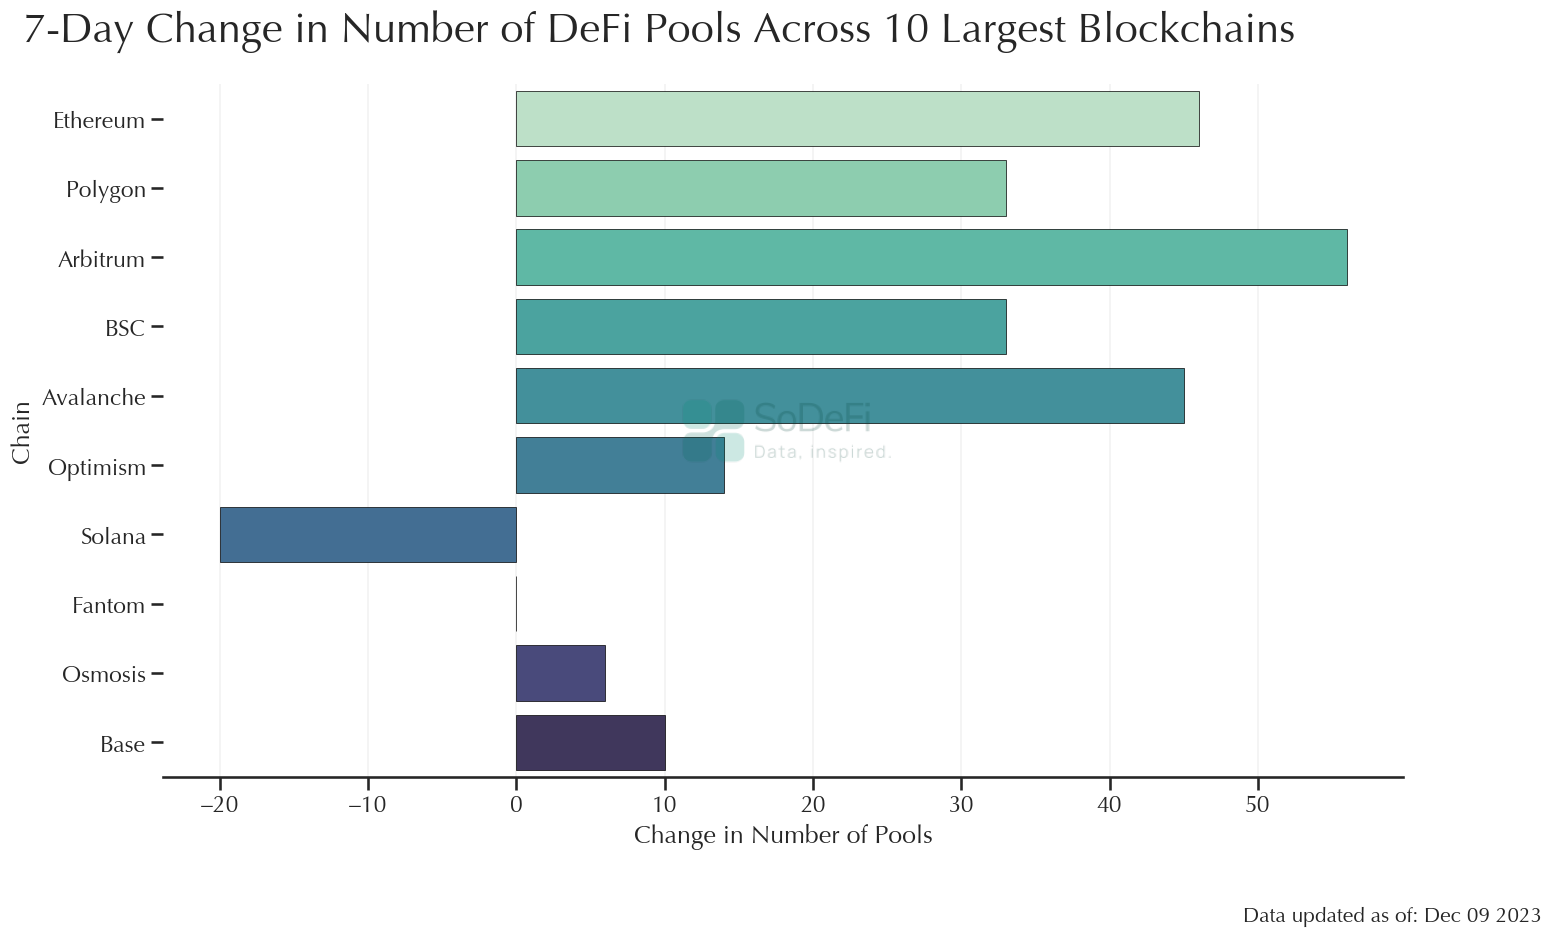

In [19]:
# creating figure 3C - Change in Pools over 7 Days

#create a chart of total TVL by chain
fig, ax = plt.subplots(figsize=(16,9))

#setting collor palette to 'makr_r'
sns.set_palette('mako_r', 12)

#charting the data
ax = sns.barplot(x='Change', y='Chain', data=pools_data_week, linewidth=0.5, edgecolor='black')

#setting up title and labels
ax.set_title('7-Day Change in Number of DeFi Pools Across 10 Largest Blockchains',
             y=1.05, size=30, weight='bold', x=0.4)
ax.set(xlabel ='Change in Number of Pools',
       ylabel = 'Chain')
sns.despine(left=True)
plt.grid(False)

#adding a string of when data was updated to the  right bottom corner of exhibit
plt.text(0.8, -0.05, date, fontsize=15, transform=plt.gcf().transFigure)

#adding watermark
imagebox = OffsetImage(img, zoom=0.8, alpha=0.2)
imagebox.image.axes = ax
ao = AnnotationBbox(imagebox, (0.5, 0.5), xycoords='axes fraction', bboxprops={'lw':0})
ao.patch.set_alpha(0)
ax.add_artist(ao)

plt.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5, axis='x')

#saving plot

fig.savefig('/Users/karolk/Python_Work/DeFi_Viz/Figures/3C.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()
plt.cla()
plt.clf()
plt.close()

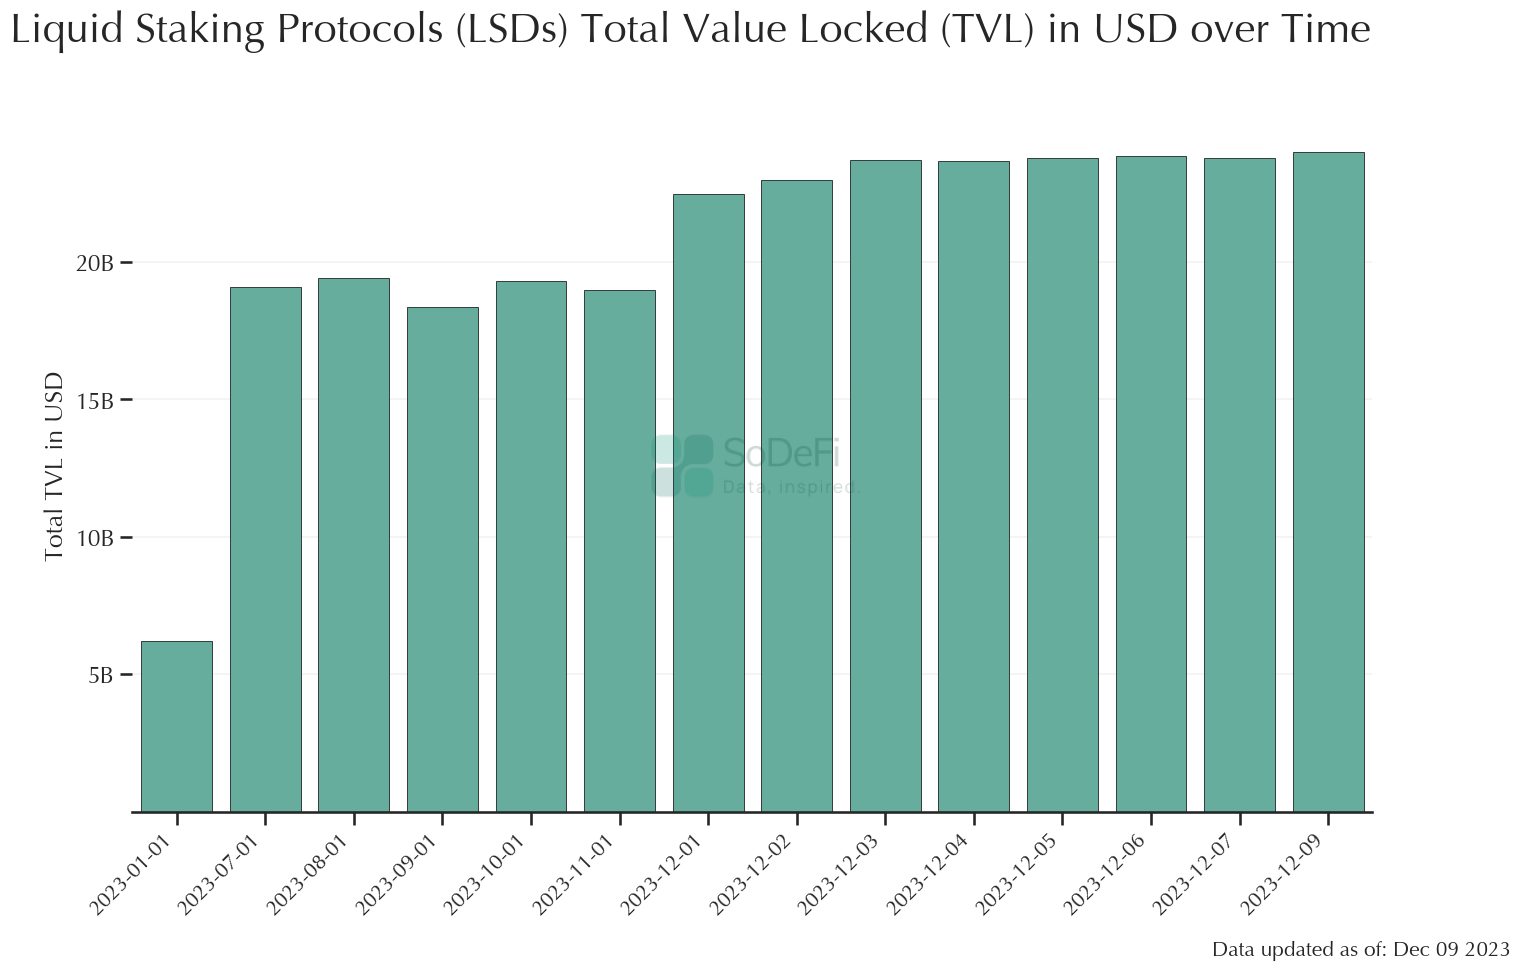

In [20]:
# creating figure 4A - total TVL of liquid stakers over time

#plot the total TVL by date
fig, ax = plt.subplots()
ax.figure.set_size_inches(16, 9)

#plotting the data
ax = sns.barplot(x='date', y='tvlUsd', data=liquid_data_tvl, color='#5AB9A4', linewidth=0.5, edgecolor='black')

#despine the chart
sns.despine(left=True)

#adjusting the y axis ticks scale
plt.yticks([5000000000, 10000000000,15000000000, 20000000000],['5B', '10B', '15B', '20B'])

#set title and labels for the chart
ax.set_title('Liquid Staking Protocols (LSDs) Total Value Locked (TVL) in USD over Time',
             y=1.1, size=30, weight='bold', x=0.45)
ax.set_xlabel(None)
ax.set_ylabel('Total TVL in USD')

#adding a string of when data was updated to the  right bottom corner of exhibit
plt.text(0.8, -0.05, date, fontsize=15, transform=plt.gcf().transFigure)

#rotating the x-axis labels
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", size=15)

#adding watermark
imagebox = OffsetImage(img, zoom=0.8, alpha=0.2)
imagebox.image.axes = ax
ao = AnnotationBbox(imagebox, (0.5, 0.5), xycoords='axes fraction', bboxprops={'lw':0})
ao.patch.set_alpha(0)
ax.add_artist(ao)

plt.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5, axis='y')


#saving chart as png file in folder called 'Charts'
fig.savefig('/Users/karolk/Python_Work/DeFi_Viz/Figures/4A.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()
plt.cla()
plt.clf()
plt.close()

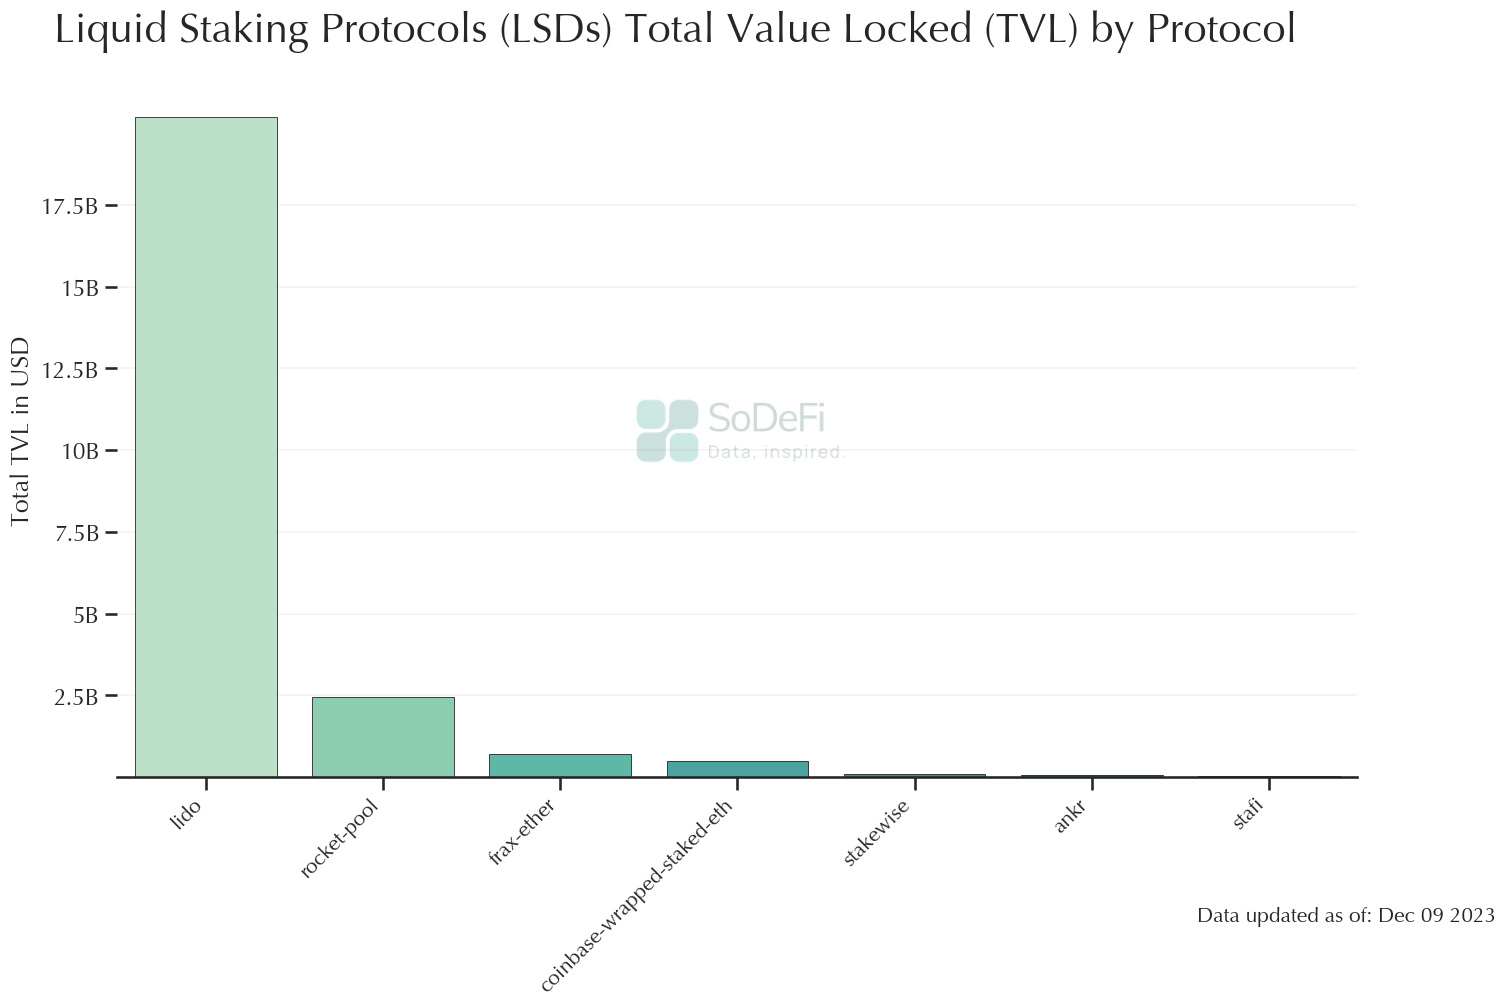

In [21]:
# creating figure 4B - Liquid Staking TVL by Protocol

#create a chart of total TVL by chain
fig, ax = plt.subplots(figsize=(16,9))

#setting collor palette to 'makr_r'
sns.set_palette('mako_r', 12)

#charting the data
ax = sns.barplot(x='Project', y='TVL', data=liquid_data_projects, linewidth=0.5, edgecolor='black')

#setting up title and labels
ax.set_title('Liquid Staking Protocols (LSDs) Total Value Locked (TVL) by Protocol',
             y=1.05, size=30, weight='bold', x=0.45)
ax.set(xlabel =None,
       ylabel = 'Total TVL in USD')
sns.despine(left=True)
plt.grid(False)

#adjusting the y axis ticks scale
plt.yticks([2500000000, 5000000000,7500000000, 10000000000, 12500000000, 15000000000, 17500000000],['2.5B', '5B', '7.5B', '10B', '12.5B', '15B', '17.5B'])

#adjust labels on x-axis to 45 degrees
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", size=15)

#adding a string of when data was updated to the  right bottom corner of exhibit
plt.text(0.8, -0.05, date, fontsize=15, transform=plt.gcf().transFigure)

#adding watermark
imagebox = OffsetImage(img, zoom=0.8, alpha=0.2)
imagebox.image.axes = ax
ao = AnnotationBbox(imagebox, (0.5, 0.5), xycoords='axes fraction', bboxprops={'lw':0})
ao.patch.set_alpha(0)
ax.add_artist(ao)

plt.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5, axis='y')

#saving plot

fig.savefig('/Users/karolk/Python_Work/DeFi_Viz/Figures/4B.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()
plt.cla()
plt.clf()
plt.close()


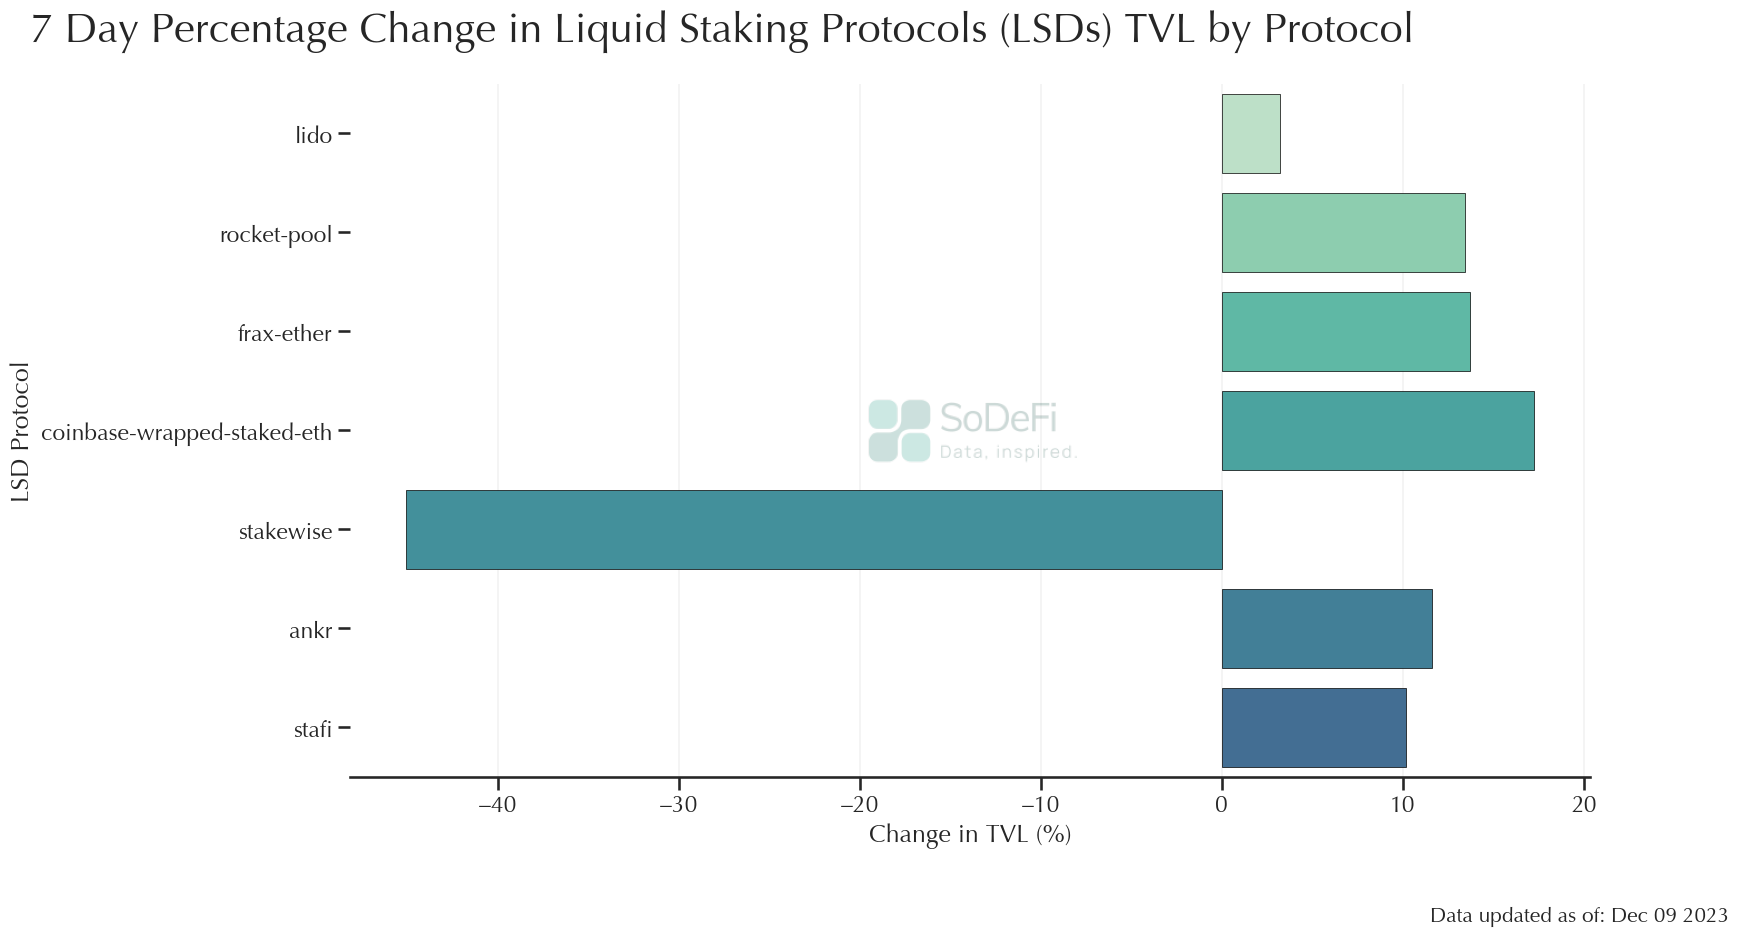

In [22]:
# creating figure 4C - % Change in TVL over 7 Days

#create a chart of total TVL by chain
fig, ax = plt.subplots(figsize=(16,9))

#setting collor palette to 'makr_r'
sns.set_palette('mako_r', 12)

#charting the data
ax = sns.barplot(x='Change', y='Project', data=liquid_data_projects, linewidth=0.5, edgecolor='black')

#setting up title and labels
ax.set_title('7 Day Percentage Change in Liquid Staking Protocols (LSDs) TVL by Protocol',
             y=1.05, size=30, weight='bold', x=0.3)
ax.set(xlabel ='Change in TVL (%)',
       ylabel = 'LSD Protocol')
sns.despine(left=True)
plt.grid(False)

#adding a string of when data was updated to the  right bottom corner of exhibit
plt.text(0.8, -0.05, date, fontsize=15, transform=plt.gcf().transFigure)

#adding watermark
imagebox = OffsetImage(img, zoom=0.8, alpha=0.2)
imagebox.image.axes = ax
ao = AnnotationBbox(imagebox, (0.5, 0.5), xycoords='axes fraction', bboxprops={'lw':0})
ao.patch.set_alpha(0)
ax.add_artist(ao)

plt.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5, axis='x')

#saving plot

fig.savefig('/Users/karolk/Python_Work/DeFi_Viz/Figures/4C.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()
plt.cla()
plt.clf()
plt.close()